# Light Curves from Lauren macArthur


- date 2024-02-28
- update : 2024-02-29
  

``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

 

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

In [2]:
saveDir = "./lc_output"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [3]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 50  # 100

In [4]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"
#band = "i"
#tract = 5615
band = "g"
tract = 3864

calibFluxStr = "apFlux_35_0_instFlux"

In [5]:
# Testing on an HSC RC2 run
# butlerRoot = "/repo/main"
# collection = "HSC/runs/RC2/w_2024_06/DM-42797"

# collectionStr = collection.replace("/", "_")
# instrument = "HSC"
# skymapName = "hsc_rings_v1"
# band = "i"
# tract = 9813

# calibFluxStr = "apFlux_12_0_instFlux"

In [6]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871


In [7]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 383} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240206T160257Z id=784d3e58-a02e-4e74-9d48-76b15ff6921c)


## isolated_star_sources

In [8]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [9]:
isolatedStarSourcesFull.head()

index            sourceId          visit  detector          ra  \
500    311  178244556209258808  2023111500491         0  122.502825   
501    372  178244559430484341  2023111500494         0  122.502823   
502    258  178244565872935171  2023111500500         0  122.502858   
503    314  178244569094160699  2023111500503         0  122.502824   
504    241  178244578757837042  2023111500512         0  122.502819   

           dec   physical_filter band  apFlux_35_0_instFlux  \
500 -36.181384  SDSSg_65mm~empty    g           6954.547665   
501 -36.181375  SDSSg_65mm~empty    g           6000.281781   
502 -36.181370  SDSSg_65mm~empty    g           7359.760396   
503 -36.181370  SDSSg_65mm~empty    g           5964.736858   
504 -36.181375  SDSSg_65mm~empty    g           6700.209257   

     apFlux_35_0_instFluxErr            x            y  apFlux_50_0_instFlux  \
500               520.601516  3098.827835  3522.560081           6379.547641   
501               521.054306  2546.181966  3530.582966           5241.074769   
502               540.127003  1429.358613  3546.919371           7627.589051   
503               548.627765   879.671071  3553.554222           6905.047960   
504               494.652187  3645.608646  2034.918576           6804.684425   

     apFlux_50_0_instFluxErr  apFlux_50_0_flag  localBackground_instFlux  \
500               738.847123             False                 -0.214291   
501               740.013040             False                 -0.219130   
502               767.235233             False                 -0.048147   
503               780.137957             False                  0.101498   
504               709.608399             False                 -0.078709   

     localBackground_flag  source_row  obj_index  
500                 False         311          0  
501                 False         372          0  
502                 False         258          0  
503                 False         314          0  
504                 False         241          0

In [10]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

Empty DataFrame
Columns: [index, sourceId, visit, detector, ra, dec, physical_filter, band, apFlux_35_0_instFlux, apFlux_35_0_instFluxErr, x, y, apFlux_50_0_instFlux, apFlux_50_0_instFluxErr, apFlux_50_0_flag, localBackground_instFlux, localBackground_flag, source_row, obj_index]
Index: []

In [11]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


In [12]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched souces from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=8999 matched souces from original 32277)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 176 objects from 640).


In [13]:
sorted_visitList = sorted(visitList)

In [14]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [15]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [16]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

In [17]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

In [18]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2023111600642
Number of objects with >=3 matches before sourceTable_visit exsistence check: 176
Number of objects with >=3 matches after sourceTable_visit exsistence check: 176


## CCD Visit Table

In [19]:
# need also. ["zeroPoint","airmass"]

In [20]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))

In [21]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
40919696896  2023051100262  SDSSr_65mm~empty    r  239.946728 -24.053747   

             zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                              
40919696896       56.749516  27.690649  7.814408  11.197219  7.856582   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
40919696896          0.026538         0.014041        42   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
40919696896             -0.007038              0.000486   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
40919696896               0.032627               0.014318   

             psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
ccdVisitId                                                     
40919696896                0.107089                 0.110564   

             psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  \
ccdVisitId                                                        
40919696896                       0.013839             0.879543   

             maxDistToNearestPsf   effTime  effTimePsfSigmaScale  \
ccdVisitId                                                         
40919696896          2160.236328  0.207786              0.016376   

             effTimeSkyBgScale  effTimeZeroPointScale       decl  detector  \
ccdVisitId                                                                   
40919696896           2.679237               0.157862 -24.053747         0   

               seeing  skyRotation                   expMidpt   expMidptMJD  \
ccdVisitId                                                                    
40919696896  1.761132   322.911701 2023-05-12 01:08:56.302993  60076.047874   

             expTime                   obsStart  obsStartMJD  darkTime  xSize  \
ccdVisitId                                                                      
40919696896     30.0 2023-05-12 01:08:41.302993   60076.0477   30.2434   4071   

             ySize       llcra     llcdec       ulcra     ulcdec       urcra  \
ccdVisitId                                                                     
40919696896   3999  239.935567 -24.128924  240.029265 -24.062574  239.957876   

                urcdec       lrcra     lrcdec   airmass   medianE  
ccdVisitId                                                         
40919696896 -23.978569  239.864202 -24.044875  1.823818  0.007055

In [22]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [23]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)
# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)
matchedObjIdList = list(set(dataJoined["obj_index"]))

In [24]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  178737264120037383  2.360580e+06  11168.946762         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.02353                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  2.314004e+06     12706.439084              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        22.009709            0.044321                 False      6   

           visit  detector          ra        dec   physical_filter band  \
0  2023112900609         0  122.432448 -36.180699  SDSSg_65mm~empty    g   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr           x          y  \
0         107272.719701               768.262999  376.820045  59.643899   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0         110056.613568              1051.688254             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                   0.57012                 False           6        157   

        psfSn     psfMag  psfMagErr  psfInstMag  psfGausFluxRatio  psfSigma  \
0  211.352076  15.467453   0.005137   18.823989          1.020128  4.804937   

       skyBg  expTime   expMidptMjd  nSource   medianE  \
0  39.792904     30.0  60278.318588      422  0.021092   

   psfStarScaledDeltaSizeScatter  astromOffsetStd  psfTraceRadiusDelta  
0                       0.025715         0.007786             1.021497

In [25]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

for objIndex in matchedObjIdList:
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    psfMagStdMmag = np.std(psfMagDiffMmag)
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    psfMagDiffMmagDfList.append(psfMagDiffMmag)

    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [26]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  178737264120037383  2.360580e+06  11168.946762         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.02353                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  2.314004e+06     12706.439084              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        22.009709            0.044321                 False      6   

           visit  detector          ra        dec   physical_filter band  \
0  2023112900609         0  122.432448 -36.180699  SDSSg_65mm~empty    g   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr           x          y  \
0         107272.719701               768.262999  376.820045  59.643899   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0         110056.613568              1051.688254             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                   0.57012                 False           6        157   

        psfSn     psfMag  psfMagErr  psfInstMag  psfGausFluxRatio  psfSigma  \
0  211.352076  15.467453   0.005137   18.823989          1.020128  4.804937   

       skyBg  expTime   expMidptMjd  nSource   medianE  \
0  39.792904     30.0  60278.318588      422  0.021092   

   psfStarScaledDeltaSizeScatter  astromOffsetStd  psfTraceRadiusDelta  \
0                       0.025715         0.007786             1.021497   

   psfMagDiffMmag  psfMagDiffChi  raDiffMas  decDiffMas  raCosDecDiffMas  
0       -8.361111      -1.478513  -2.969936    1.513431        -0.488087

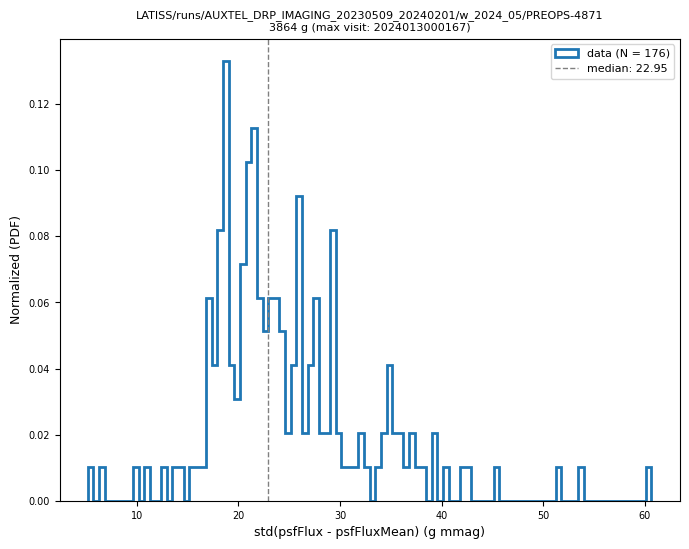

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

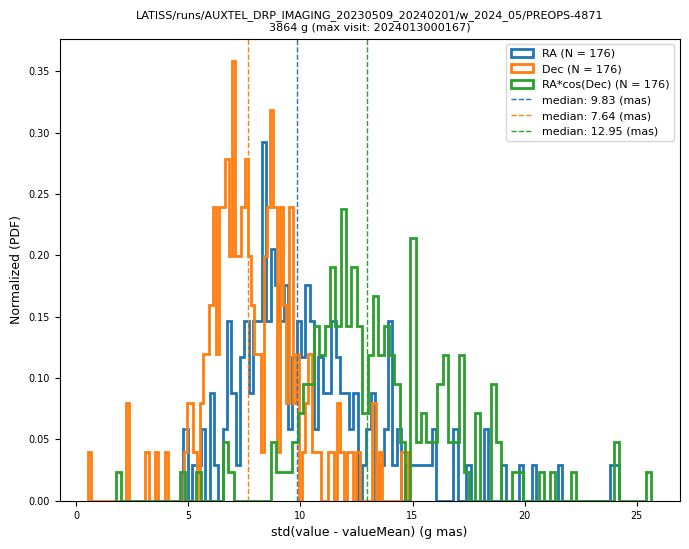

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

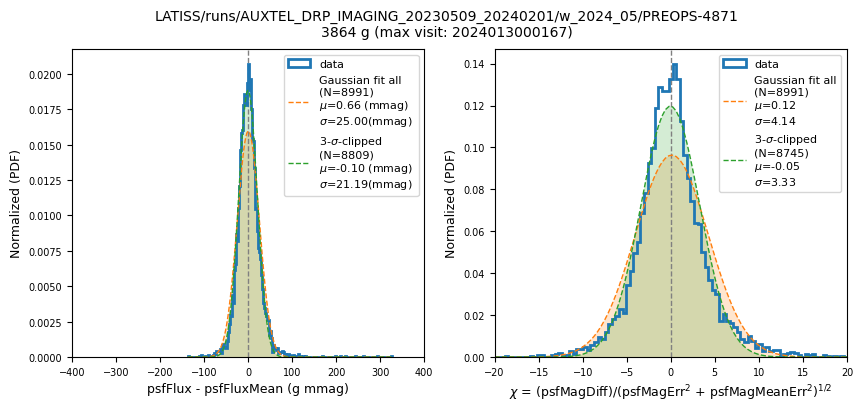

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [30]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

Large Std: objectIndex = 1048  number of matches = 24
Large Std: objectIndex = 540  number of matches = 49
Large Std: objectIndex = 547  number of matches = 55
Large Std: objectIndex = 1061  number of matches = 17
Large Std: objectIndex = 1065  number of matches = 14
Large Std: objectIndex = 1080  number of matches = 14
Large Std: objectIndex = 58  number of matches = 66
Large Std: objectIndex = 573  number of matches = 44
Large Std: objectIndex = 1097  number of matches = 5
Large Std: objectIndex = 1128  number of matches = 3
Large Std: objectIndex = 1136  number of matches = 3
Large Std: objectIndex = 1165  number of matches = 6
Large Std: objectIndex = 656  number of matches = 19
Large Std: objectIndex = 671  number of matches = 36
Large Std: objectIndex = 160  number of matches = 117
Large Std: objectIndex = 1188  number of matches = 5
Large Std: objectIndex = 685  number of matches = 3
Large Std: objectIndex = 247  number of matches = 83
Large Std: objectIndex = 251  number of mat

numObj = 3 [with obj_index = 623]
numObj = 6 [with obj_index = 327]
numObj = 49 [with obj_index = 540]


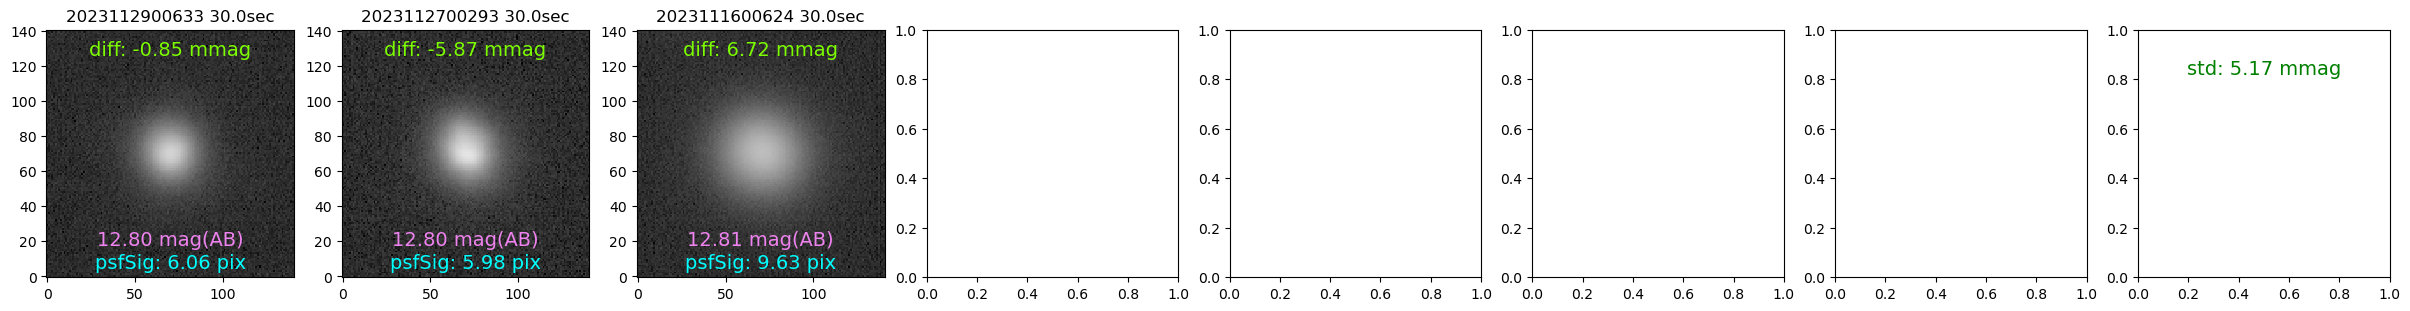

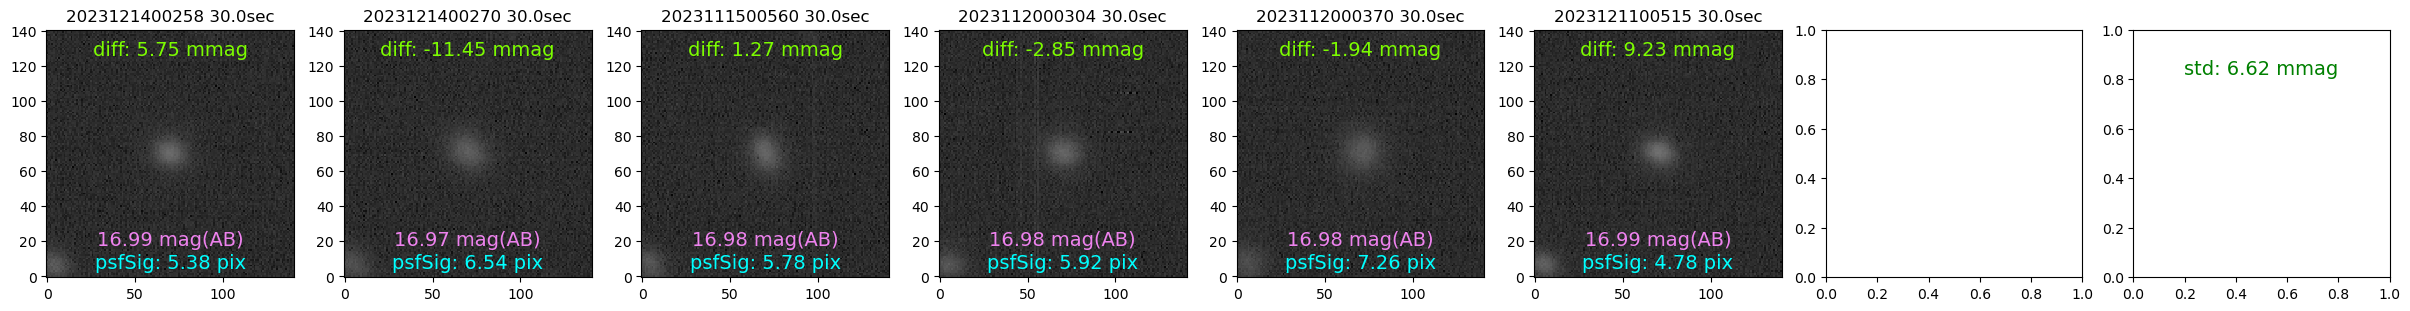

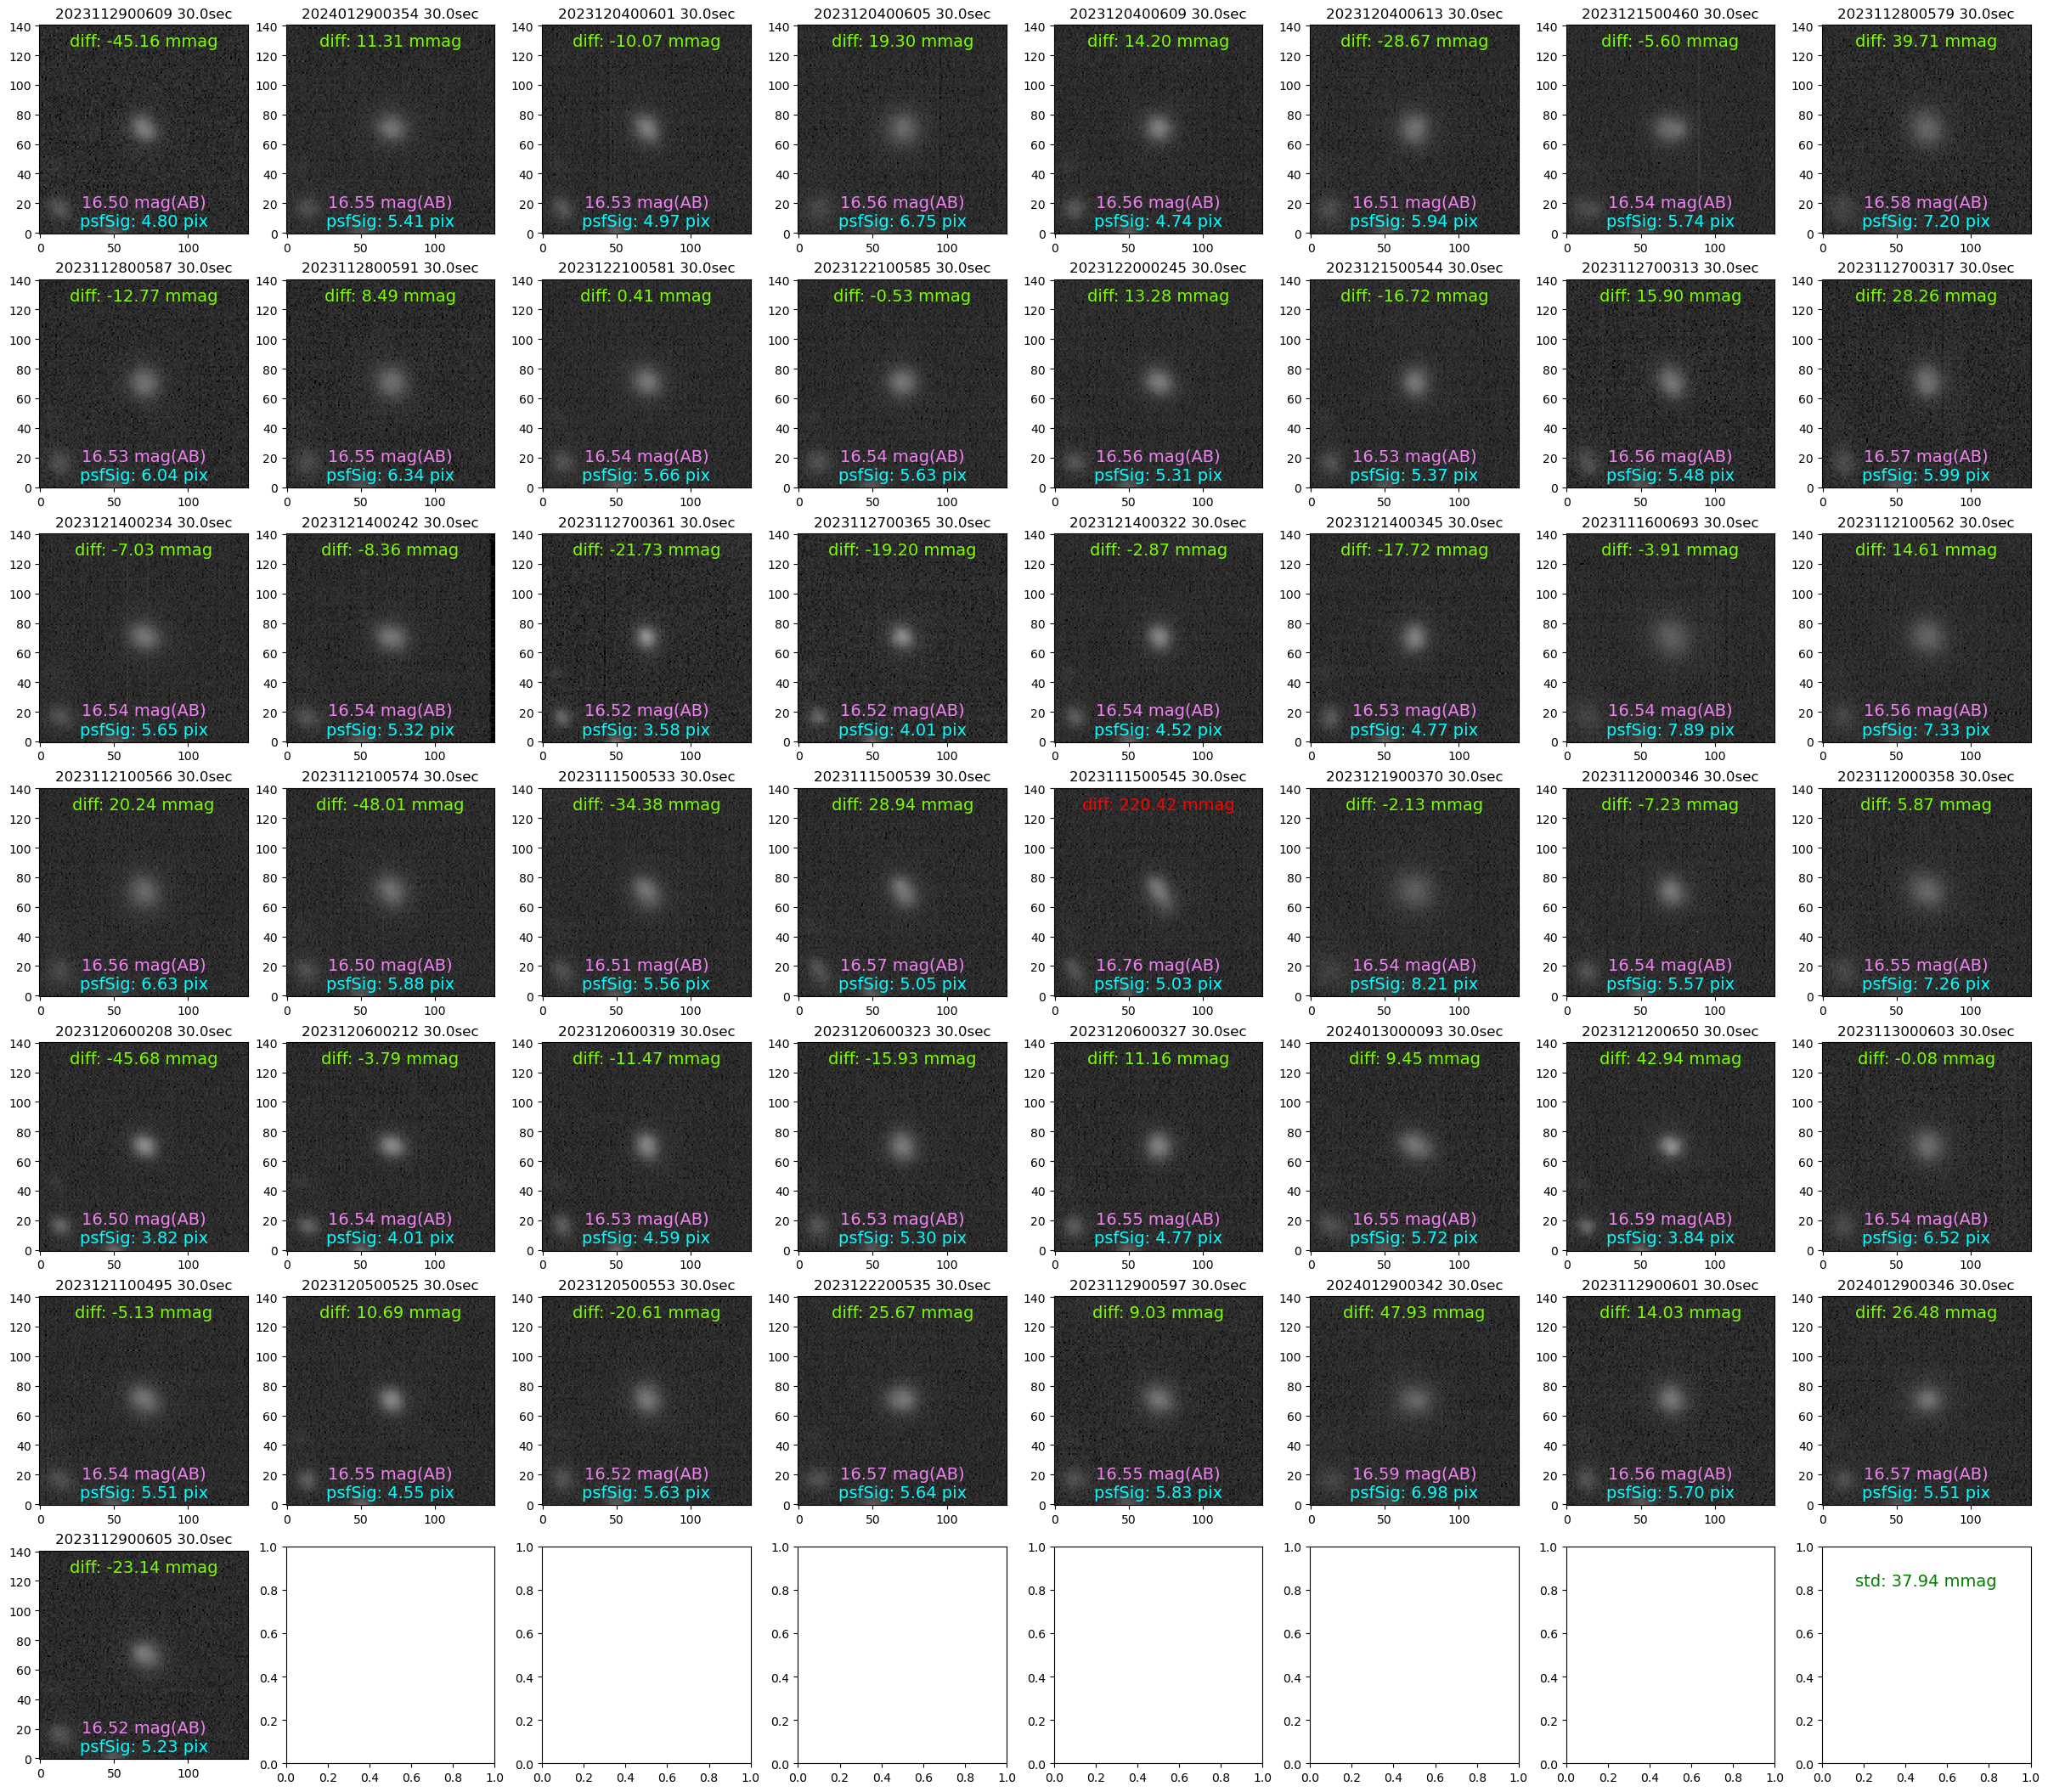

In [31]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} {}sec".format(visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

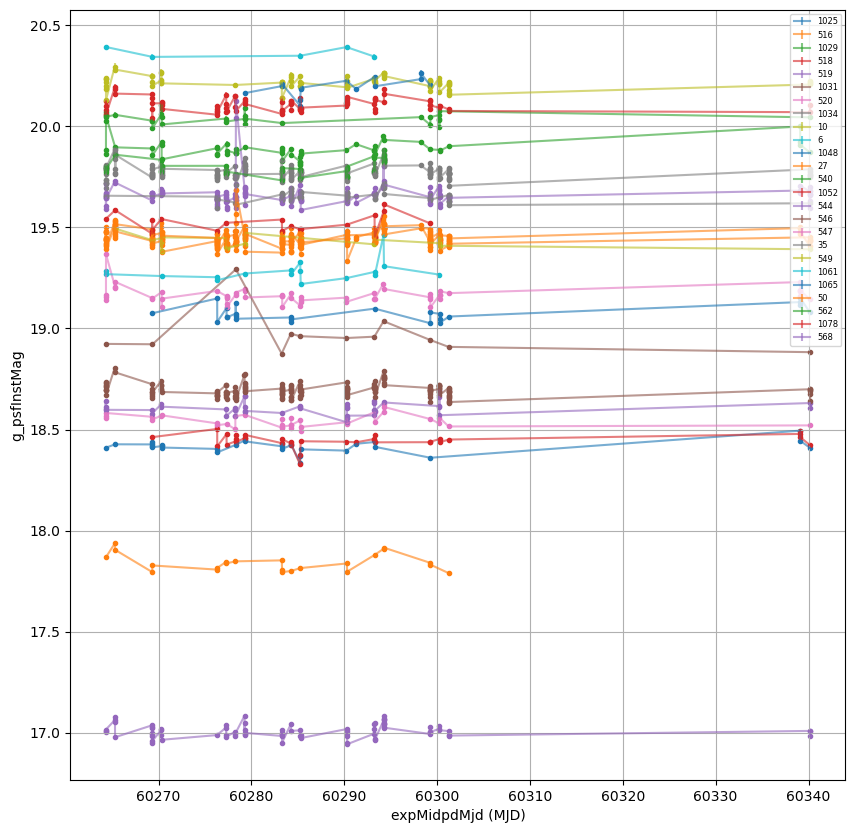

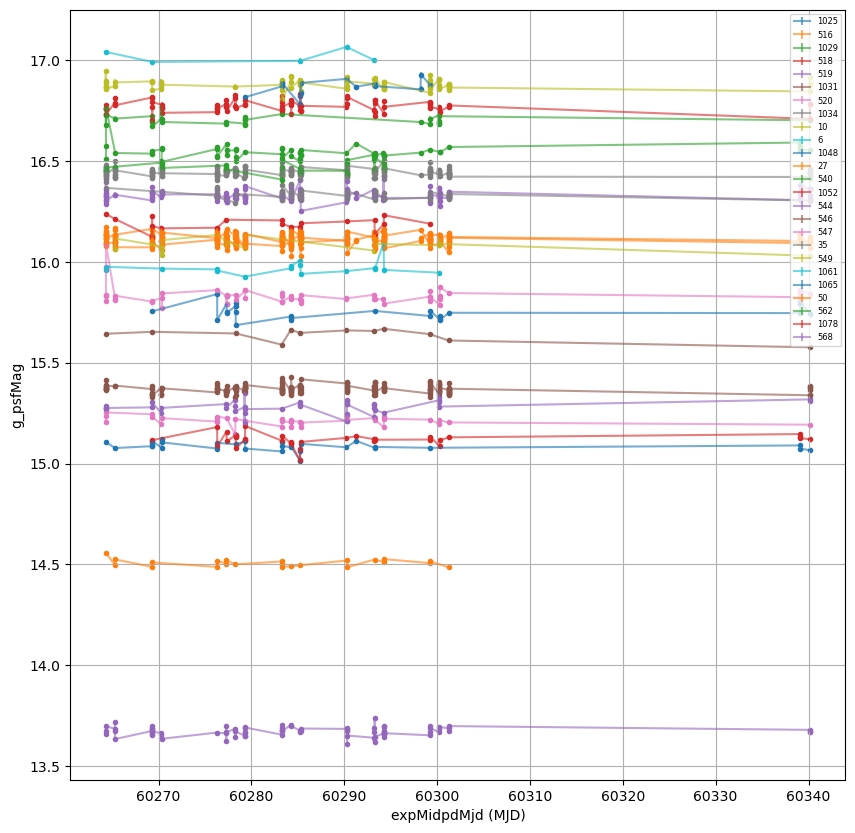

In [32]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

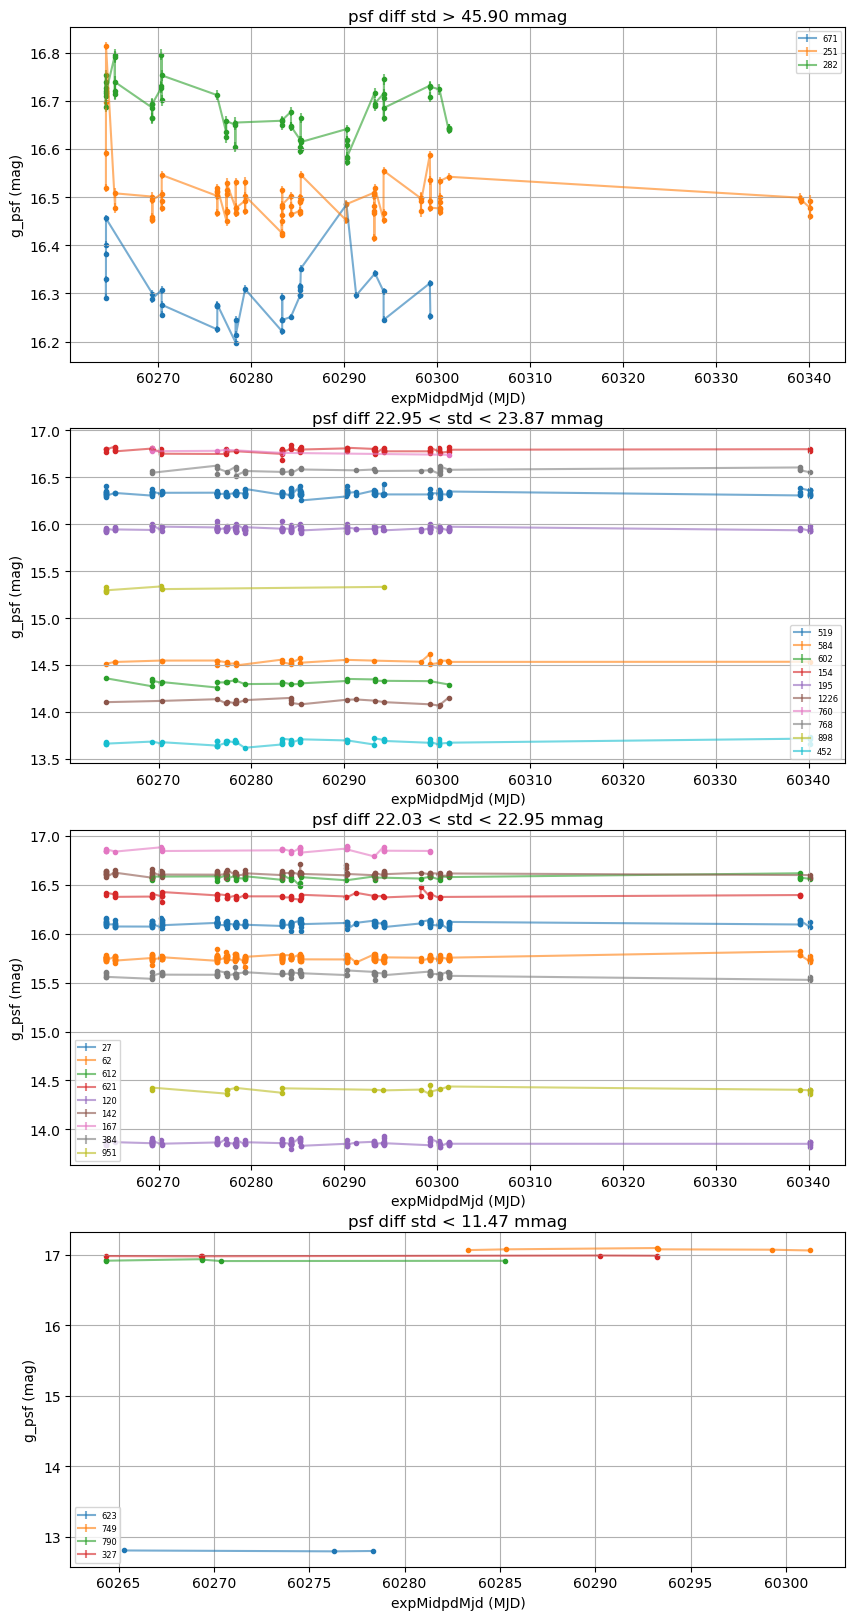

In [33]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [34]:
print(sorted_visitList)

[2023111500491, 2023111500494, 2023111500497, 2023111500500, 2023111500503, 2023111500506, 2023111500509, 2023111500512, 2023111500515, 2023111500518, 2023111500521, 2023111500524, 2023111500527, 2023111500530, 2023111500533, 2023111500536, 2023111500539, 2023111500542, 2023111500545, 2023111500548, 2023111500551, 2023111500554, 2023111500557, 2023111500560, 2023111600624, 2023111600630, 2023111600633, 2023111600636, 2023111600639, 2023111600642, 2023111600645, 2023111600648, 2023111600651, 2023111600654, 2023111600657, 2023111600660, 2023111600681, 2023111600684, 2023111600687, 2023111600690, 2023111600693, 2023111600696, 2023111600699, 2023111600702, 2023111600705, 2023111600708, 2023111600711, 2023112000304, 2023112000307, 2023112000310, 2023112000313, 2023112000316, 2023112000319, 2023112000322, 2023112000325, 2023112000328, 2023112000331, 2023112000334, 2023112000337, 2023112000340, 2023112000343, 2023112000346, 2023112000349, 2023112000352, 2023112000355, 2023112000358, 202311200

In [35]:
airmassDict

{2023112900609: 1.015901869363584,
 2024012900354: 1.0819399361680264,
 2023112900613: 1.013988909906738,
 2024012900358: 1.0761320760867366,
 2023112900617: 1.012273806915011,
 2023112900621: 1.0107607258984235,
 2023112900625: 1.009438039965784,
 2023112900629: 1.008282677465234,
 2023112900633: 1.007370386866402,
 2023120400507: 1.0995492977750025,
 2023120400511: 1.0930883701793233,
 2023120400515: 1.0860711509496455,
 2023120400519: 1.0801050628656672,
 2023120400523: 1.0742732078196744,
 2023120400527: 1.0687599477262164,
 2023120400531: 1.0635341409038632,
 2023120400535: 1.0585569741919778,
 2023120400539: 1.0538530064867715,
 2023120400543: 1.0493794619080228,
 2023120400547: 1.0445015307231855,
 2023120400551: 1.040551949154267,
 2023120400555: 1.0368374280844674,
 2023120400559: 1.03335985037103,
 2023120400563: 1.0301003404917084,
 2023120400585: 1.0183872075841092,
 2023120400589: 1.0162635837941887,
 2023120400593: 1.0143267935212241,
 2023120400597: 1.0122760604210819,
 

ValueError: x and y must have same first dimension, but have shapes (419,) and (418,)

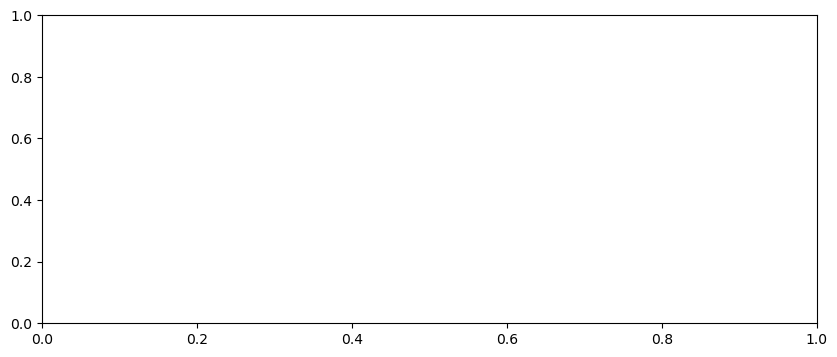

In [36]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
ax2.set_ylim(27,28.5)